In [246]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sb
import matplotlib.pyplot as plt

def imput_adata(sample):
    adata = sc.read_mtx(sample+'/matrix.mtx.gz')
    adata = adata.T
    bar = pd.read_csv(sample+'/barcodes.tsv.gz', header=None)
    fea = pd.read_csv(sample+'/features.tsv.gz', header=None, sep='\t')
    bar.columns = ['barcodes']
    fea.columns = ['ID', 'name', 'type']
    adata.obs_names = bar.iloc[:,0]
    adata.var = fea
    adata.var_names = fea.iloc[:,1]
    adata.var_names_make_unique()
    adata
    return adata

# 将所有矩阵合并
def concat_adata(adatas, sampleNames):
    
    # 进行数据合并
    adata_concat = adatas[0].concatenate(adatas[1:], batch_categories=sampleNames)
    return adata_concat
    
# 查看所有细胞中线粒体基因的含量
def show_mito(adata, sample_name):
    mito_genes = adata.var_names.str.startswith('MT-')
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    adata.obs['mt_frac'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    plt.hist(adata.obs['mt_frac'])
    plt.title
    plt.savefig('figures/mt_fraction'+ sample_name +'.svg')
    return adata
    
# 查看基因表达情况
def show_expr(adata, sample_name):
    sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle('Covariates for filtering')
    sb.distplot(adata.obs['total_counts'], kde=False, ax=axs[0])
    sb.distplot(adata.obs['total_counts'][adata.obs['total_counts'] < 10000], kde=False, bins=40, ax=axs[1])
    fig.savefig('figures/Covariates'+ sample_name +'.svg')
    return adata
    
# 预处理
def pp(adata, sample_name,do_harmony=True,):
    # 过滤低表达的基因
    sc.pp.filter_cells(adata, min_genes=5)  # 过滤一个细胞中表达少于五个基因的细胞样本 
    sc.pp.filter_genes(adata, min_cells=5)  # 过滤在少于五个细胞中表达的基因
    sc.pp.filter_cells(adata, min_counts=30)   # 过滤每个细胞中计数少于29个的细胞样本 

    # 过滤线粒体核糖体基因
    rp_genes = adata.var_names.str.startswith('RP')
    mt_genes = adata.var_names.str.startswith('MT-')
    adata = adata[:, ~(rp_genes + mt_genes)]
    adata = adata[adata.obs['mt_frac'] < 0.2]
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    return adata

def MergeSubAdata(adata, subAdata, obsName, subObsName):
    obs = pd.Series(list(adata.obs[obsName].copy()), index=adata.obs_names)
    subObs = pd.Series(list(subAdata.obs[subObsName].copy()), index=subAdata.obs_names)
    obs.loc[subObs.index] = subObs
    return pd.DataFrame(obs, columns=[obsName])

def marker(adata, groupby, method='wilcoxon', prefix=''):
    sc.tl.rank_genes_groups(adata, groupby = groupby, method = method)
    sc.tl.dendrogram(adata, groupby=groupby, use_rep='X_pca_harmony')
    sc.pl.rank_genes_groups_dotplot(adata, groupby = groupby, save=prefix+groupby+'.svg')
    return adata

# 降维聚类
def clu(adata, key_added, 
        n_neighbors=50, 
        n_pcs=30, 
        rep='X_pca_harmony', 
        resolution=1, 
        do_scrublet=True, 
        do_harmony=True):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.external.pp.scrublet(adata, random_state=112)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    sc.tl.pca(adata, svd_solver='arpack')
    if do_harmony:
        sc.external.pp.harmony_integrate(adata, key='batch',max_iter_harmony=20)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, key_added=key_added, resolution=resolution)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata
    

In [237]:
import os
import re

BCMdir = "/data/BCM/BCM_Matrix/"
BCMFile = os.listdir(BCMdir)
adatas = []
for bcm in BCMFile:
  outPath = BCMdir+bcm+'/filtered_feature_bc_matrix'
  adata = imput_adata(outPath)
  adatas.append(adata)
    
adata_con = concat_adata(adatas, BCMFile)
adata_con
    

AnnData object with n_obs × n_vars = 77397 × 33538
    obs: 'batch'
    var: 'ID', 'name', 'type'

In [240]:
adata_con.obs['batch'].unique()

['TNBC1', 'TNBC4', 'TNBC5', 'HER2BC10', 'TNBC3', 'TNBC6', 'LABC7', 'TNBC2', 'LABC9', 'LABC8']
Categories (10, object): ['TNBC1', 'TNBC4', 'TNBC5', 'HER2BC10', ..., 'LABC7', 'TNBC2', 'LABC9', 'LABC8']

In [294]:
adata_con.var = adata[0].var
adata_con.var_names = adata_con.var['name']
sc.write("BCM-cancat.h5ad", adata_con)

... storing 'name' as categorical
... storing 'type' as categorical


In [4]:
adata_con = sc.read_h5ad('BCM-concat.h5ad')

/home/rzh/BCY/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


filtered out 5643 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:07)


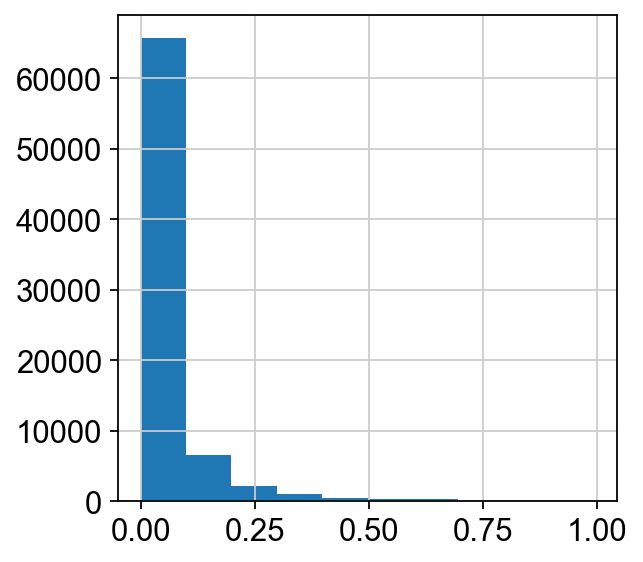

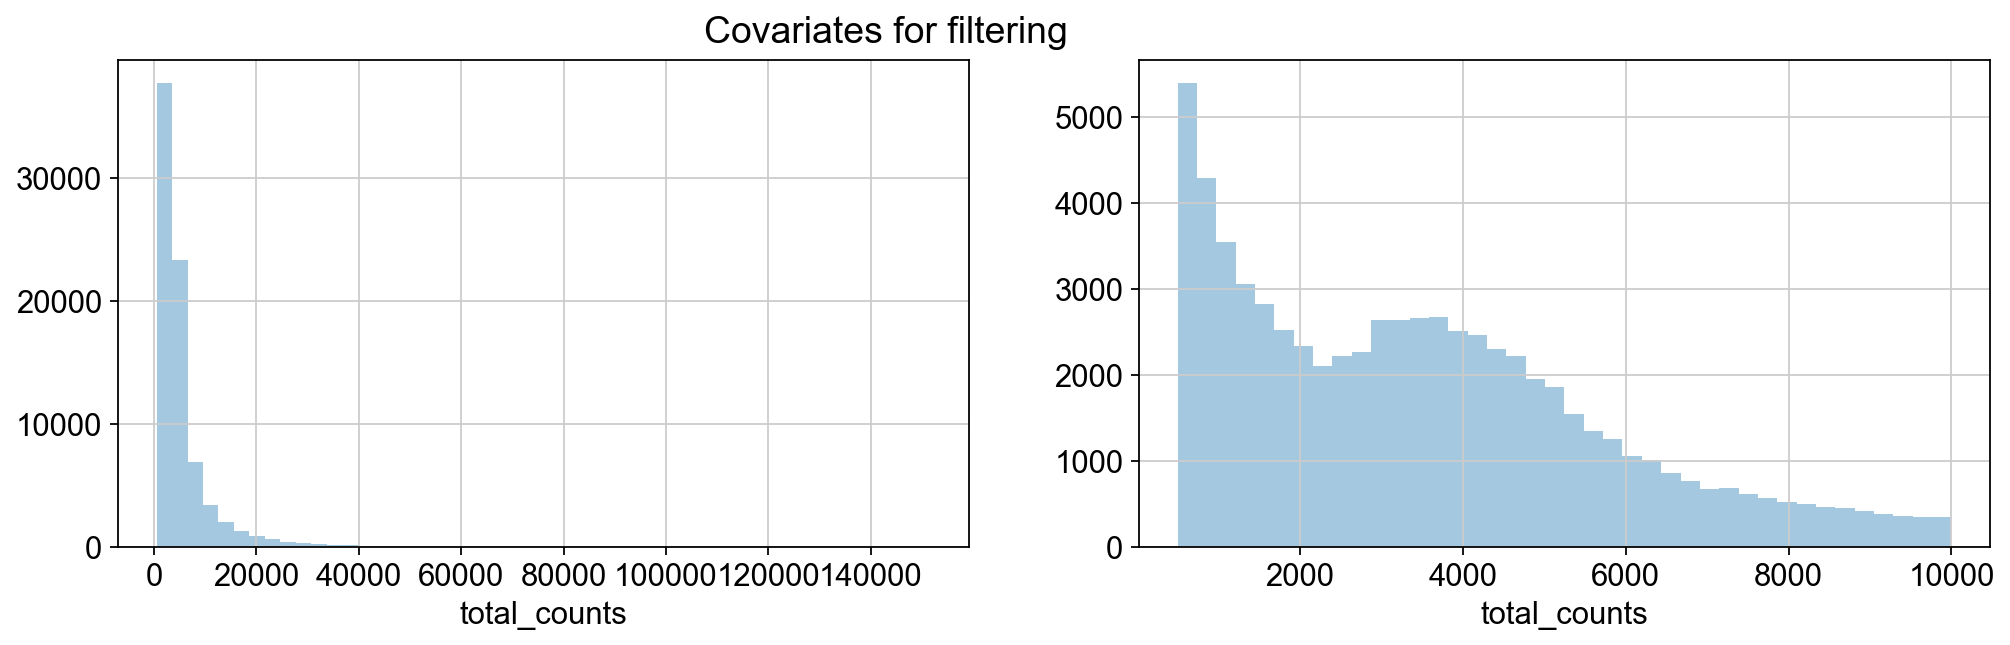

In [242]:
adata_con.var_names = adata_con.var['name']
adata_con.var_names_make_unique()
adata_con = show_mito(adata_con, 'BCM')
adata_con = show_expr(adata_con, 'BCM')
adata_con = pp(adata_con, 'BCM')

In [243]:
adata_con

AnnData object with n_obs × n_vars = 72257 × 27739
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts'
    var: 'ID', 'name', 'type', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

leiden-major Cell number: 72257
Running Scrublet
filtered out 1 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:01)
extracting highly variable genes
    finished (0:00:05)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:04)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.19
Detected doublet rate = 3.7%
Estimated detectable doublet fraction = 66.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.6%
    Scrublet finished (0:06:28)
69553 Cells retained after scrublet, 2704 cells reomved.
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:00)


2024-04-08 09:34:41,795 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2024-04-08 09:37:50,612 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-04-08 09:37:51,839 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2024-04-08 09:39:46,810 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2024-04-08 09:41:32,028 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2024-04-08 09:43:33,739 - harmonypy - INFO - Iteration 4 of 20
Iteration 4 of 20
2024-04-08 09:45:23,060 - harmonypy - INFO - Converged after 4 iterations
Converged after 4 iterations


computing neighbors


/home/rzh/BCY/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished (0:01:42)
computing UMAP
    finished (0:03:20)
running Leiden clustering
    finished (0:06:16)


... storing 'name' as categorical
... storing 'type' as categorical


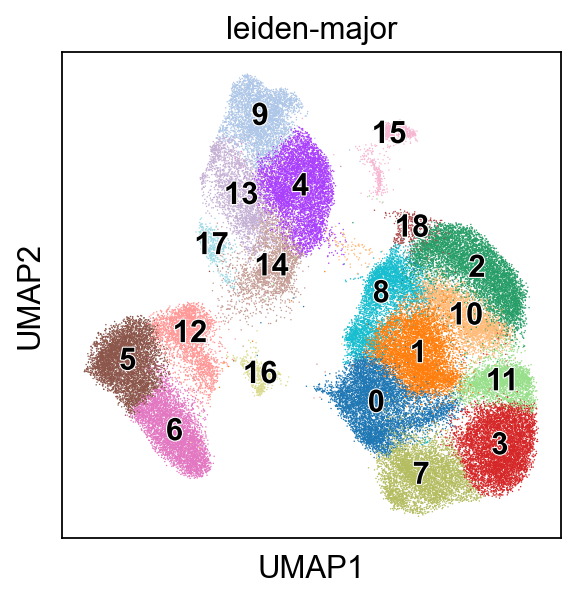

ranking genes
    finished (0:10:45)
Storing dendrogram info using `.uns['dendrogram_leiden-major']`


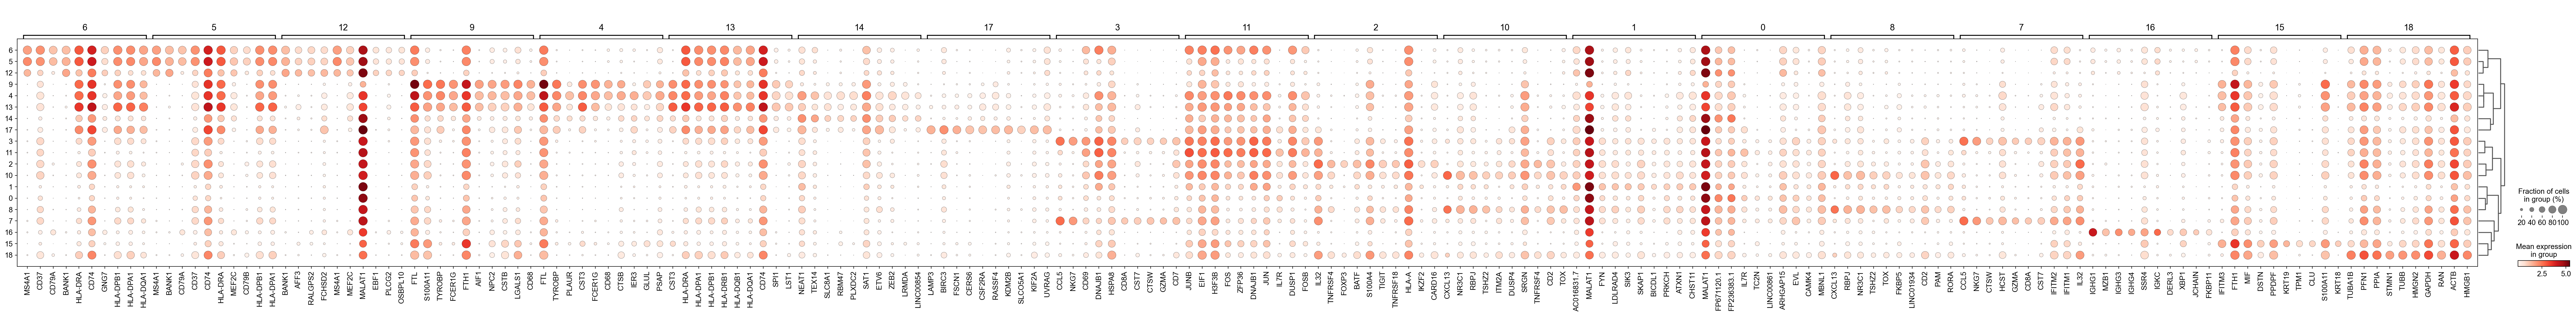

In [247]:
adata_con = clu(adata_con, 'leiden-major', do_scrublet=True)
adata_con = marker(adata_con, 'leiden-major')

... storing 'major-type' as categorical


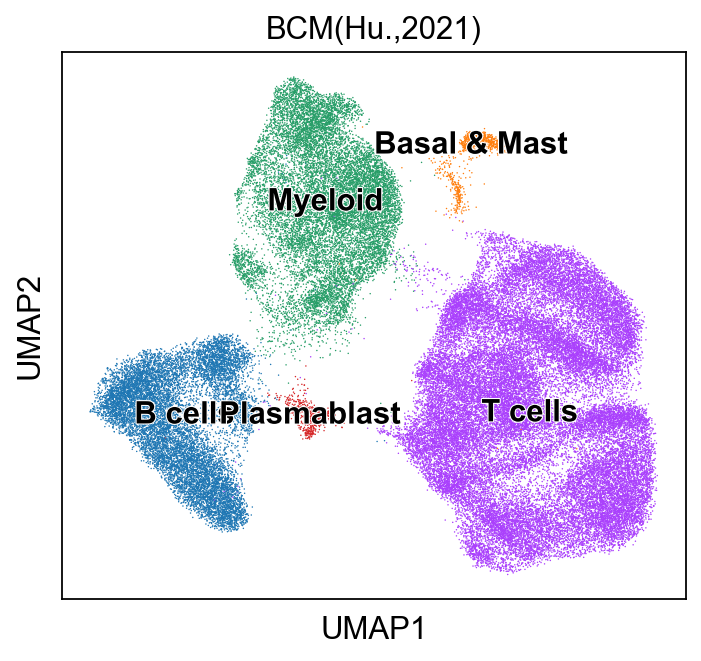

In [250]:
adata_con.obs['major-type'] = 'unassigned'
adata_con.obs.loc[  
    adata_con.obs["leiden-major"].isin(['12', '6', '5']), "major-type"
] = "B cells"
adata_con.obs.loc[  
    adata_con.obs["leiden-major"].isin(['4', '9', '13', '14', '17']), "major-type"
] = "Myeloid"
adata_con.obs.loc[  
    adata_con.obs["leiden-major"].isin(['0','1', '2', '3', '7', '8', '10', '11', '18']), "major-type"
] = "T cells"
adata_con.obs.loc[  
    adata_con.obs["leiden-major"].isin(['16']), "major-type"
] = "Plasmablast"
adata_con.obs.loc[  
    adata_con.obs["leiden-major"].isin(['15']), "major-type"
] = "Basal & Mast"
folder='figure-4.10'
fig,ax = plt.subplots(figsize=(5,4.5))
sc.pl.umap(adata_con, color='major-type', ax=ax, title='BCM(Hu.,2021)', legend_loc='on data', legend_fontoutline=True)
fig.savefig(folder+'/BCM-major.png', dpi=300)

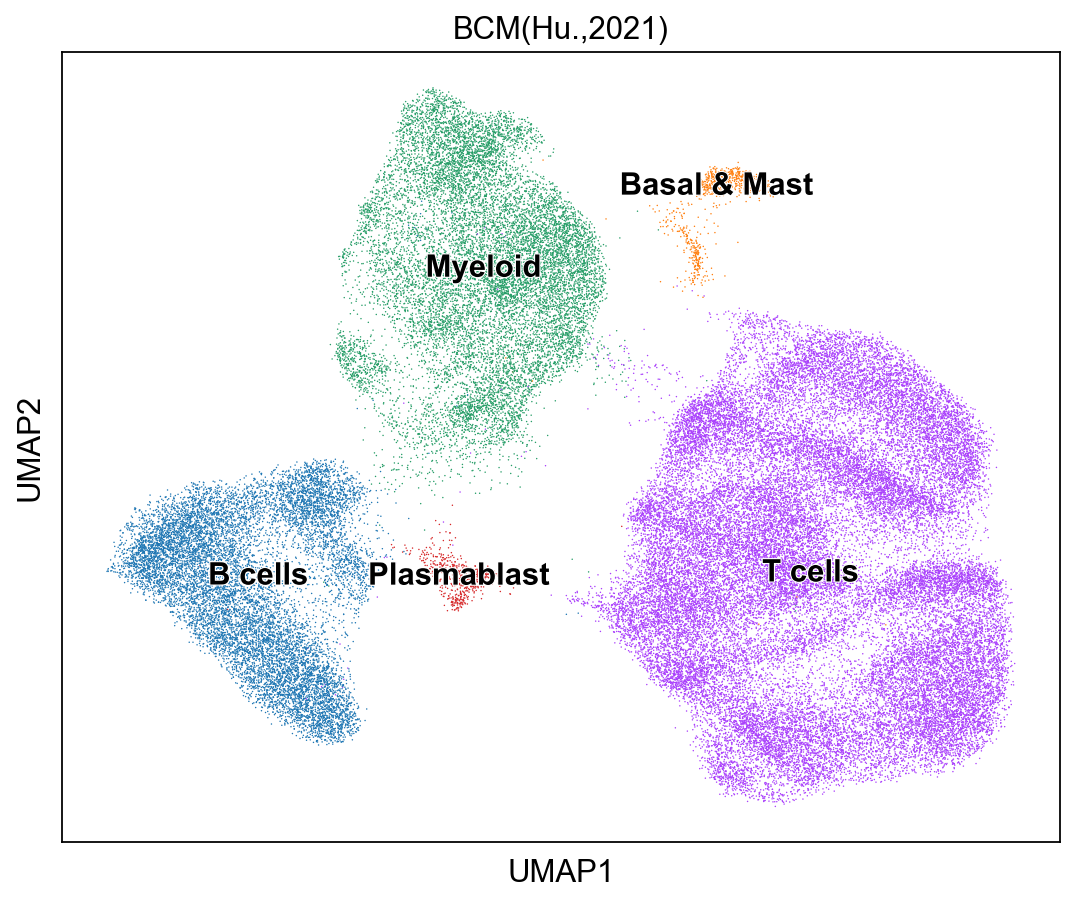

In [251]:
# adata_con = sc.read_h5ad('BCM-major.h5ad')
folder='figure-4.10'
fig,ax = plt.subplots(figsize=(8,6.5))
sc.pl.umap(adata_con, color='major-type', ax=ax, title='BCM(Hu.,2021)', legend_loc='on data', legend_fontoutline=True)
fig.savefig(folder+'/BCM-major.png', dpi=300)

In [249]:
sc.pl.umap(adata_con, color=['CD3D', 'MS4A1', 'TYROBP', 'KRT18',
                             'TPSAB1', 'JCHAIN'])

In [275]:
adata_con.obs['molecular_type'] = 'TNBC'
adata_con.obs.loc[adata_con.obs['batch'].isin(['LABC7', 'LABC8', 'LABC9']),'molecular_type'] = 'Luminal A'
adata_con.obs.loc[adata_con.obs['batch'].isin(['HER2BC10']),'molecular_type'] = 'HER2+'
adata_con.obs['molecular_type']

barcodes
AAACCTGAGAAGGCCT-1-TNBC1         TNBC
AAACCTGCAACACCCG-1-TNBC1         TNBC
AAACCTGCAAGCTGGA-1-TNBC1         TNBC
AAACCTGCAATGAAAC-1-TNBC1         TNBC
AAACCTGCACCAACCG-1-TNBC1         TNBC
                              ...    
TTTGTCAGTGCTCTTC-1-LABC8    Luminal A
TTTGTCAGTTAGTGGG-1-LABC8    Luminal A
TTTGTCAGTTCACCTC-1-LABC8    Luminal A
TTTGTCATCAGTACGT-1-LABC8    Luminal A
TTTGTCATCTGCTTGC-1-LABC8    Luminal A
Name: molecular_type, Length: 69553, dtype: object

In [276]:
sc.write('BCM-preF.h5ad', adata_con)

... storing 'molecular_type' as categorical


In [256]:
# GENE EXPRESSION OF T,B cells
fig, ax = plt.subplots(2, 3,figsize=(12,7), constrained_layout=True)
for i,g in enumerate(['CD3D', 'MS4A1', 'TYROBP', 'KRT18', 'TPSAB1', 'JCHAIN']):
  sc.pl.umap(adata_con, color=g, ax=ax[int(i/3)][i%3], show=False)
  ax[int(i/3)][i%3].set_xlabel("UMAP1")
  ax[int(i/3)][i%3].set_ylabel("UMAP2")
fig.savefig(f"{folder}/bcm-major-marker.png", dpi=300, bbox_inches='tight')